# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state

### Your code/answer goes here.
- Initial State: empty board
- Actions: drop a piece on arbitrary vertical line
- Transition model: the new state resulting from dropping a piece
- Goal state: forming a sequence of 4 to win the game

How big is the search space?

### Your code/ answer goes here.
Each grid has three different state, empty(0),the player(1), the opponent(-1). Hence, in a ($m * n$) board, the search space is less than $3^{m * n}$ because several sequences of 4 does not exist.

In [462]:
# Resets the namespace by removing all names defined by the user, if called without arguments. It can reduce the frequency of restarting kernel to clean all variables.
%reset -f

In [463]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')


## Task 2: Game Environment and Random Agent [2 point]

Use a numpy character array as the board.

In [464]:
def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

board = empty_board()
print(board)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors for the players use 'x' and 'o' to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 'x')`, where board is the current board position and player is the player whose next move it is and who the agent should play.

Implement the board and helper functions for:

* The transition model (result).
* The utility function.
* Check for terminal states.
* A check for available actions.
* A function to visualize the board.

Make sure that all these functions work with boards of different sizes.

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected? 

In [465]:
# A function to visualize the board
def show_board(board,raw_display=False):
    tmp_board = board.copy()
    if raw_display==False:
        tmp_board = tmp_board.astype(str)
        tmp_board[tmp_board=='0'] = ' '
        tmp_board[tmp_board=='1'] = 'x'
        tmp_board[tmp_board=='-1'] = 'o'
    print(tmp_board)
    print()

### In my raw board, I would use 0, 1 and -1 respectively to represent empty grid, the piece of player 'x' and player 'o'. It may look like what I show below. 

In [466]:
show_board(board)
show_board(board,raw_display=True)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]



### I use convolution calculation in place of successive nested for loops for win detection in order to get better performance.

In [467]:
from IPython.display import Image
Image(url='https://i.stack.imgur.com/nfjuC.png', width=800)

### The function "check_win" could determine if a player wins or draw by passing parameter player. Its return values 1, 0, -1, 2 respectively represent win,draw, loss and unknown. The "unknown" means it can't determine right now, maybe next move.

In [468]:
from scipy.signal import convolve2d
# return 1 as win, 0 as draw, -1 as unknown(it means the player don't win)
# we have two players, one is using 1 as his piece, the other is using -1 as his piece
# we use sequence of 4 as winning condition.
def check_win(board,number=4):
    player = 1
    opponent = -1 
    horizontal_sequence = np.ones((1,number),dtype=int)
    vertical_sequence = np.transpose(horizontal_sequence)
    diag1_sequence = np.eye(4)
    diag2_sequence = np.fliplr(diag1_sequence)
    detection_sequences = [
        horizontal_sequence,
        vertical_sequence,
        diag1_sequence,
        diag2_sequence
    ]
    for sequence in detection_sequences:
        if (convolve2d(board == player, sequence, mode="valid") == number).any(): 
            return 1
        elif (convolve2d(board == opponent, sequence, mode="valid") == number).any():
            return -1

    if np.count_nonzero(board==0)<1: return 0
    return 2

In [469]:
# check for terminal states
# return win as 1, draw as 0, loss as -1 and 2 as non-terminal state 
def is_terminal(state,player=1,number=4):
    if player==1: opponent = -1
    else : opponent = 1

    goal = check_win(state,number)

    if 0 == goal : return 0
    elif goal==player : return 1
    elif goal==-player : return -1
    else : return goal

In [470]:
# A check for available actions.
def available_actions(board):
    """return possible actions as a vector of indices"""
    return np.where(board[0,:] == 0)[0].tolist()

show_board(board)
available_actions(board)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]



[0, 1, 2, 3, 4, 5, 6]

In [471]:
# The transition model (result)
def result(state,player,action):
    state = state.copy()
    available_r = np.where(state[:,action] == 0)[0]
    if len(available_r) > 0 :
        r = available_r[-1]
        state[r,action] = player
    return state

In [472]:
show_board(board)
print()
board = result(board,1,3)
board = result(board,-1,3)
show_board(board)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]


[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'o' ' ' ' ' ' ']
 [' ' ' ' ' ' 'x' ' ' ' ' ' ']]



In [473]:
# get player's opponent
def opponent(player=1):
    if player == 1: return -1
    else: return 1

In [474]:
#The utility function.
def utility(state,player=1):
    """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state)
    if goal == player: return 1 # win
    elif goal == opponent(player): return -1 # loss
    elif goal == 2: return None # it can't determine, maybe next move
    else: return goal # draw

In [475]:
# A completely randomized player agent
def random_player(board, player = None):
    """Simple player that chooses a random empy square. player is unused"""
    return np.random.choice(available_actions(board))

In [506]:
def switch_player(player, agent1_kernel, agent2_kernel):
    if player == 1:
        return -1, agent2_kernel
    else:
        return 1, agent1_kernel

def play(empty_board_kernel, first_move_agent, second_move_agent, first_move_agent_name='agent_1', second_move_agent_name='agent_2', N = 100, debug=False, plot=False, **kwargs):
    """Let two agents play each other N times. "agent1" starts first. "agent1" and "agent2" are agent functions that 
    get the board as the percept and return their next action."""
    if first_move_agent_name == second_move_agent_name: second_move_agent_name += '_2'

    results = {first_move_agent_name: 0, second_move_agent_name: 0, 'draw': 0}
    player_dict = {1:first_move_agent_name, -1:second_move_agent_name, 0:'draw'}

    for i in range(N):
        # board = empty_board_kernel(shape=empty_board_shape)
        board = empty_board_kernel()
        # print(board.shape)
        player, kernel = 1, first_move_agent
        if debug: 
                print('round {} :'.format(i+1))
        while True:
            a = kernel(board, player)
            board = result(board, player, a)
            if debug:
                print('after {}\'s move, the board:'.format(player_dict[player]))    
                show_board(board)

            goal = check_win(board,**kwargs)
            if goal != 2: # 2 means the state could not determine right now, maybe next move.
                results[player_dict[goal]] += 1
                break
            
            player, kernel = switch_player(player, first_move_agent, second_move_agent)

    if plot:
        plt.bar(results.keys(), results.values(), color=['red','blue','green'])
        plt.ylabel("Rounds")
        plt.title('{} vs. {} '.format(first_move_agent_name,second_move_agent_name))
        plt.show()
    return results

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected? 

### Based on the result of two random agents playing 1000 times in 10 big rounds, the random agent moved first looks like having an advantage over the other. I thought they may have equal probability to win but the results were beyond my expectation.


In [477]:
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), random_player, random_player, debug=1, N = 1, number=4))

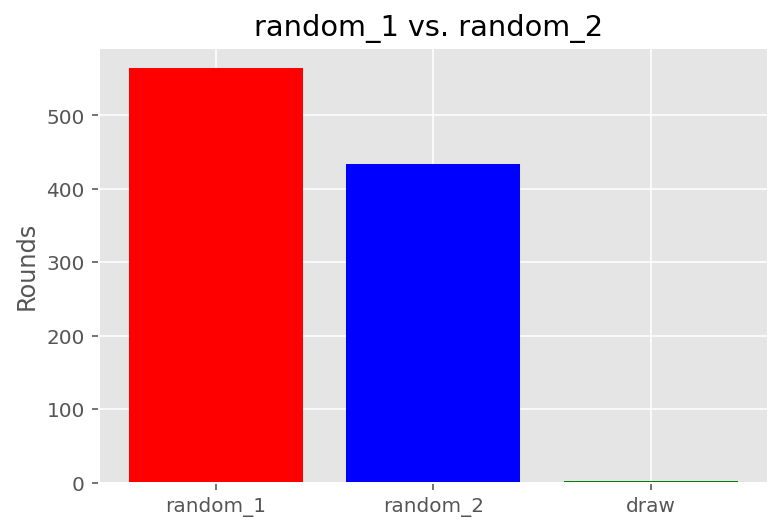

{'random_1': 564, 'random_2': 434, 'draw': 2}

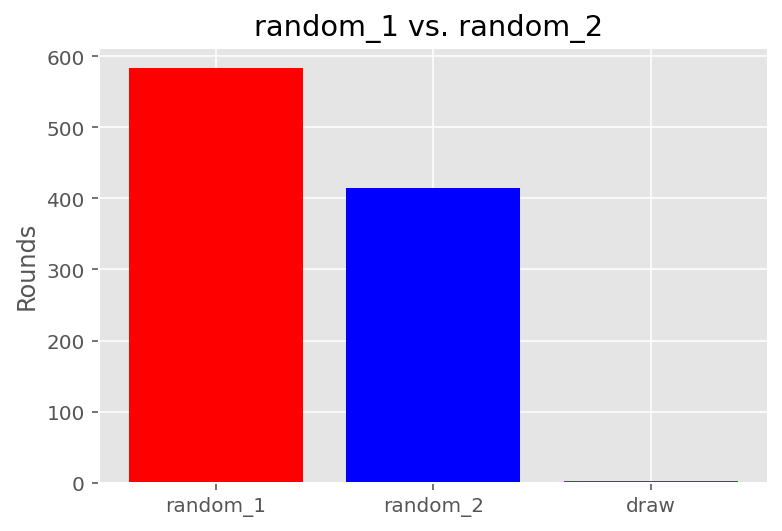

{'random_1': 583, 'random_2': 415, 'draw': 2}

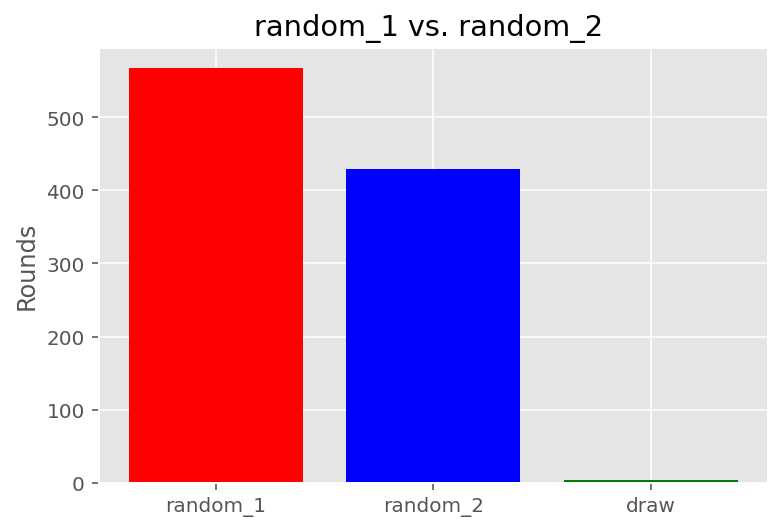

{'random_1': 567, 'random_2': 429, 'draw': 4}

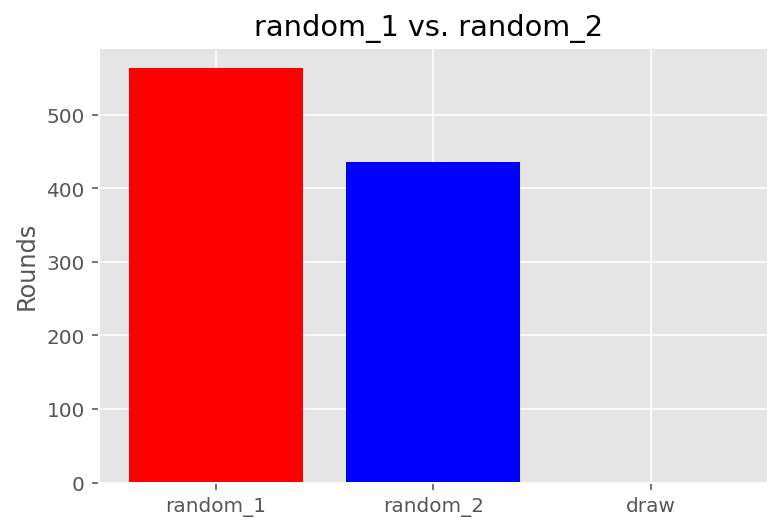

{'random_1': 563, 'random_2': 436, 'draw': 1}

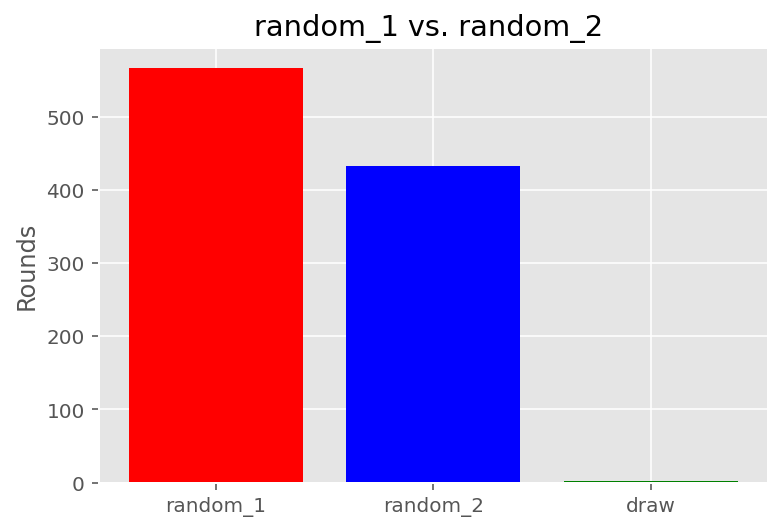

{'random_1': 566, 'random_2': 432, 'draw': 2}

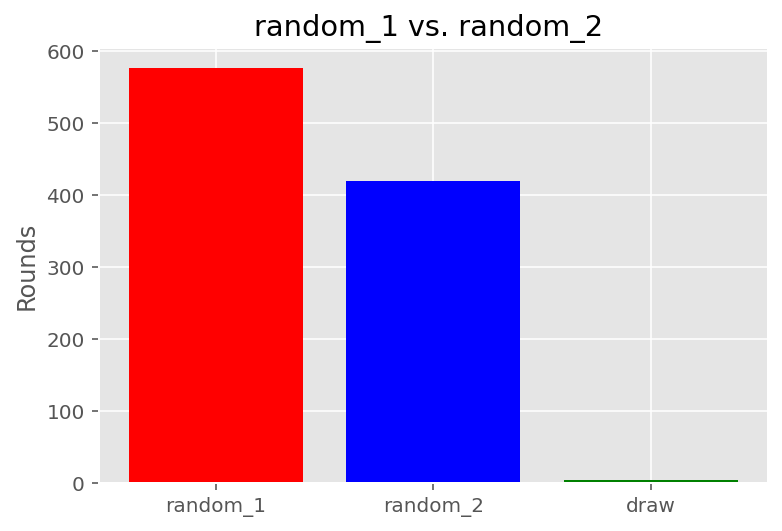

{'random_1': 576, 'random_2': 420, 'draw': 4}

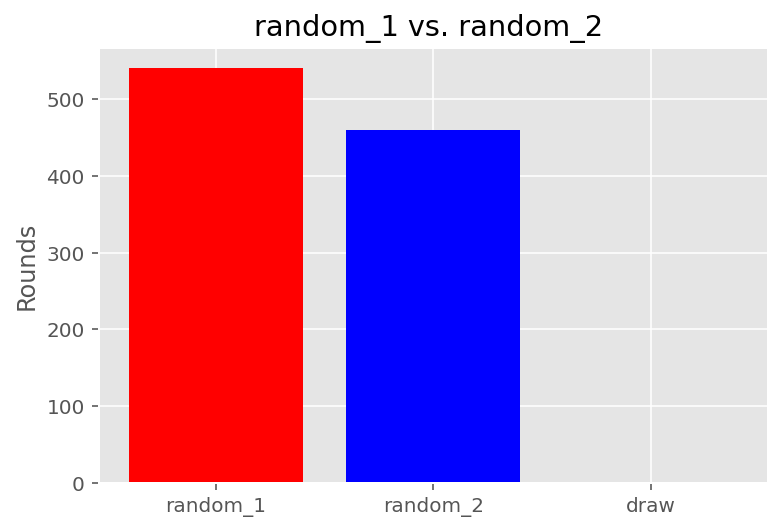

{'random_1': 540, 'random_2': 460, 'draw': 0}

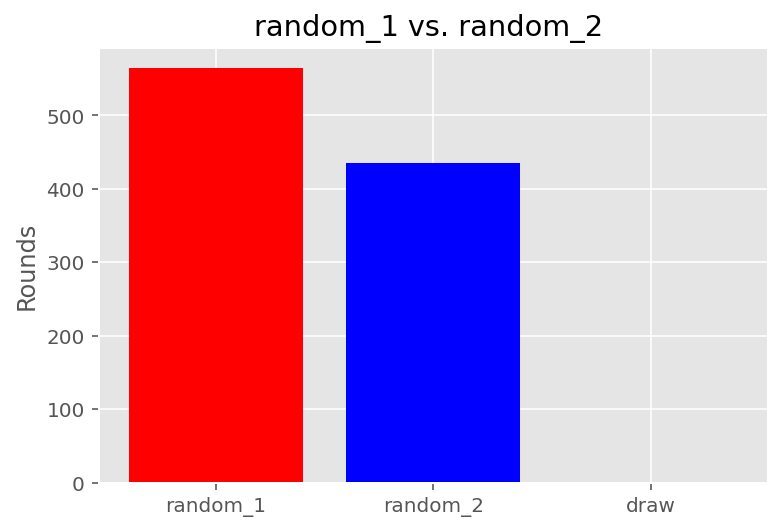

{'random_1': 564, 'random_2': 435, 'draw': 1}

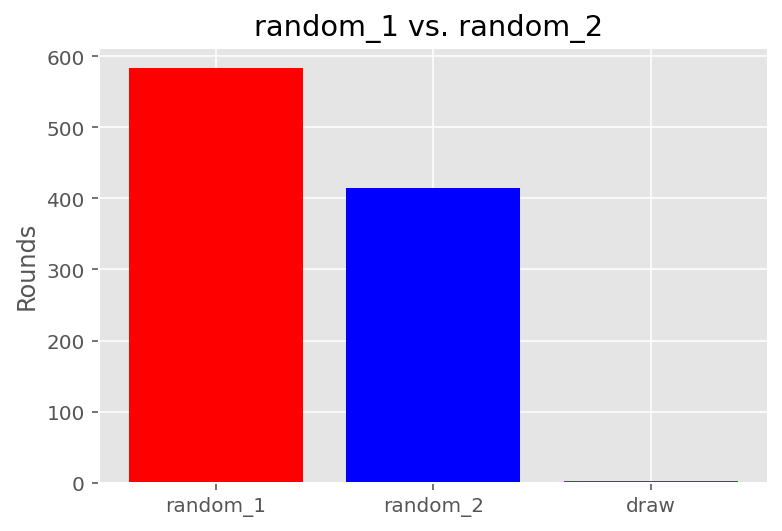

{'random_1': 583, 'random_2': 415, 'draw': 2}

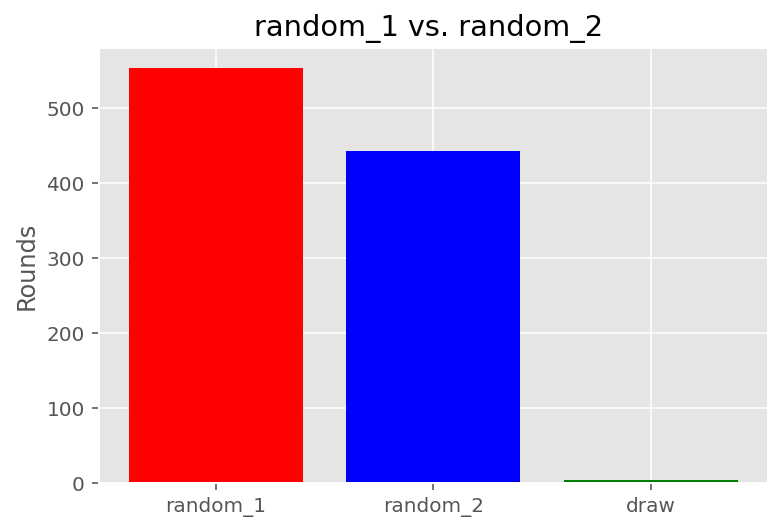

{'random_1': 553, 'random_2': 443, 'draw': 4}

963 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [507]:
%timeit -n 10 -r 1 display(play(lambda: empty_board(shape=(6,7)),random_player, random_player, first_move_agent_name='random_1', second_move_agent_name='random_2', plot=True,N = 1000, number=4))

In [479]:
# Your code/ answer goes here.

## Task 3: Minimax Search with Alpha-Beta Pruning [4 points]

### Implement the search starting from a given board and specifying the player.



__Note:__ The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [490]:
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 1):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return value, move

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in available_actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in available_actions(state):
        v2, a2 = max_value_ab(result(state, opponent(player), a), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

In [487]:
def alpha_beta_player(board, player = 1):
    value, action = alpha_beta_search(board, player)
    return action

In [508]:
%timeit -n 10 -r 1 display(play(lambda: empty_board(shape=(4,4)), alpha_beta_player, random_player, first_move_agent_name='alpha_beta_player_1', second_move_agent_name='random_2', plot=True, N = 10, number=3))

TypeError: check_win() got an unexpected keyword argument 'agent1_name'

In [386]:
# Your code/ answer goes here.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [387]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [388]:
# Your code/ answer goes here.

### Move ordering

Describe and implement a simple move ordering strategy. How does this strategy influence the time it takes to 
make a move?

In [389]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [390]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [391]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [392]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [393]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [394]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [395]:
# Your code/ answer goes here.

## Challenge task [+ 1 bonus point]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlos Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [396]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move is? You can use Pure Monte Carlo Search or any algorithms 
that you have implemented above.

In [397]:
# Your code/ answer goes here.